# swin3d_b (30 animal classes)

In [ ]:
#%%python3 -m pip install --upgrade pip

In [1]:
%pip install mediapipe=='0.10.9'
%pip install opencv-python=='4.8.0.76'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 44.8 MB/s eta 0:00:00


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from utils import VideoDataset, validate_model, train_model, display_frames

In [4]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import json

In [5]:
def save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic):
    with open(f'{save_path}/{model_name}_loss_acc_dynamic.json', 'w') as f:
        json.dump(
            {
                'train_loss_dynamic': train_loss_dynamic,
                'val_accuracy_dynamic': val_accuracy_dynamic
            },
            f)

In [6]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1
IMG_SIZE = 112

limit_list = [] #["динозавр", "пингвин", "кролик"]

min_frame_count = 25

save = True

annotations_file = "/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DF_SHORT.tsv" #  "/content/drive/MyDrive/slovo/SLOVO_DF_SHORT.tsv" #
dataloader_dir = "/home/jupyter/mnt/s3/rsl-videos/slovo/Dataloaders/animals/" #  "/content/drive/MyDrive/slovo/dataloaders/" #

train_dataloader_name = 'color_frames_train_dataloader.pth'
val_dataloader_name = 'color_frames_val_dataloader.pth'

save_path = "/home/jupyter/mnt/s3/rsl-videos/slovo/models/animals/swinb" #'/content/drive/MyDrive/slovo/models/ResNet18' # '/content/model' #

In [7]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<17,'train', np.where(video_labels['group_rank']<19,'val', 'test'))
if len(limit_list)>0:
  video_labels = video_labels[video_labels.text.isin(limit_list)]
video_labels.tail(5)

,Unnamed: 0,attachment_id,text,begin,end,group_rank,dataset
595,55,25b5fb58-46dd-4fd6-9928-734460795b22,мышь,22,83,20,test
596,56,336e0e7a-ff68-427c-9a77-52626b81edd1,паук,42,74,19,test
597,57,d0ec4c00-6ff5-4089-ac9d-5a33a76fb037,паук,3,70,20,test
598,58,59ae408b-f87a-422a-bc57-2ff5af28ee57,бабочка,2,74,19,test
599,59,e421d77c-1dcd-4124-b2a4-b2415569a4dd,бабочка,63,131,20,test


In [8]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 30. Example classes: ('пингвин', 'жираф', 'лягушка', 'бегемот', 'козел')


In [9]:
train_dataloader = torch.load(dataloader_dir + train_dataloader_name)
print(f"Train dataloader contains: {len(train_dataloader)} videos")
val_dataloader = torch.load(dataloader_dir + val_dataloader_name)
print(f"Val dataloader contains: {len(val_dataloader)} videos")

Train dataloader contains: 480 videos
Val dataloader contains: 60 videos


In [10]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  for dl in [train_dataloader, val_dataloader]:
    dl.num_workers = 0
    dl.pin_memory = True
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(f"Device: {device}")

Device: cuda


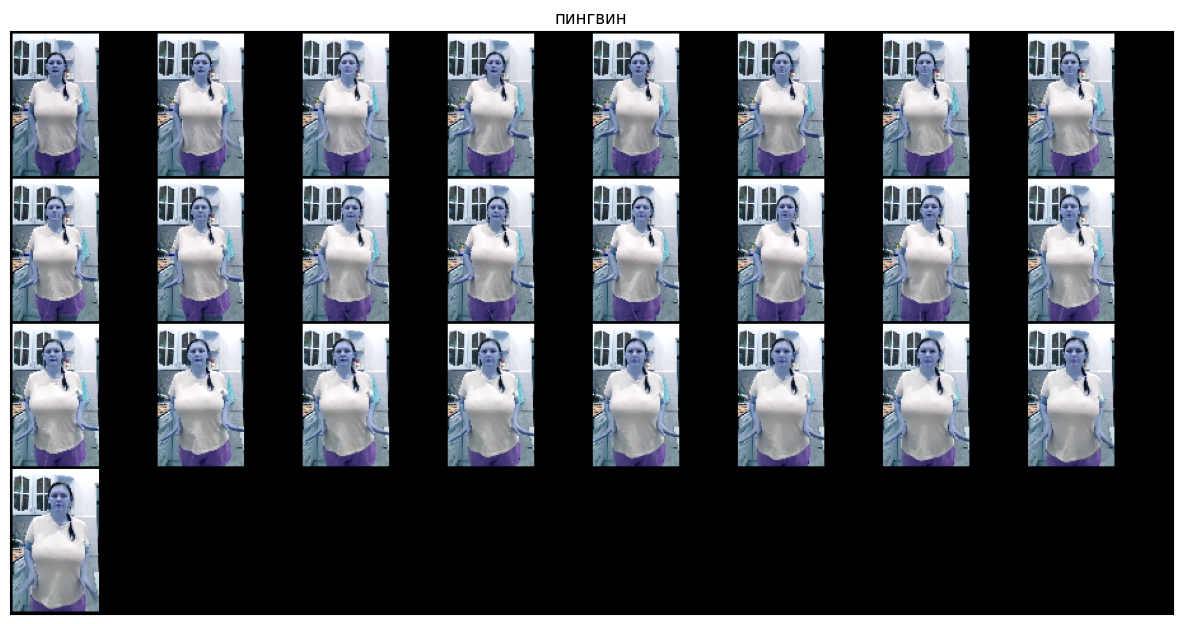

In [11]:
display_frames(n_frames=1, dataloader=train_dataloader, classes=classes)

In [12]:
frames, labels = next(iter(val_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 112, 112])
# frames = frames.permute(0,2,1,3,4) # (B, T, C, H, W) for swin
# print(f"Frames shape: {frames.shape}") #
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 25, 112, 112])
Frames shape: torch.Size([1, 25, 3, 112, 112])
Labels shape: torch.Size([1])
Labels: tensor([3])


# Swin B, $lr = 10^{-5}$

In [18]:
# https://pytorch.org/vision/main/models/generated/torchvision.models.video.swin3d_b.html#torchvision.models.video.swin3d_b
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

Linear(in_features=1024, out_features=30, bias=True)

In [14]:
frames, labels = next(iter(val_dataloader))
frames = frames.to(device)
swinb.to(device)
print(f"Output shape: {swinb(frames/255).shape}") # batch size, number of classes

Output shape: torch.Size([1, 30])


In [19]:
lr = 10**(-5)
model_name = "swinb_animals_lr10-5"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)

In [20]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)
    

Train Epoch 1/30: train_loss=3.3867; val acc=0.133
Train Epoch 2/30: train_loss=1.9361; val acc=0.667
Train Epoch 3/30: train_loss=0.4436; val acc=0.717
Train Epoch 4/30: train_loss=0.0872; val acc=0.667
Train Epoch 5/30: train_loss=0.0337; val acc=0.800
Train Epoch 6/30: train_loss=0.0119; val acc=0.767
Train Epoch 7/30: train_loss=0.0066; val acc=0.767
Train Epoch 8/30: train_loss=0.0044; val acc=0.767
Train Epoch 9/30: train_loss=0.0031; val acc=0.767
Train Epoch 10/30: train_loss=0.0023; val acc=0.767
Train Epoch 11/30: 

KeyboardInterrupt: 

# Swin CosineAnnealingLR

#https://minibatchai.com/2021/07/09/Cosine-LR-Decay.html
    #

In [ ]:
swinb = torchvision.models.video.swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
num_ftrs = swinb.head.in_features
swinb.to(device)
swinb.head = nn.Linear(num_ftrs, n_class, True)
swinb.head

In [ ]:
lr = 3 * (10**(-4))
num_epoches = 30
model_name = "swinb_animals_lrcd"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swinb.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(swinb, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(swinb, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(swinb, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.4182; val acc=0.067
Train Epoch 2/30: train_loss=3.4712; val acc=0.033
Train Epoch 3/30: train_loss=3.4558; val acc=0.033
Train Epoch 4/30: train_loss=3.4303; val acc=0.033
Train Epoch 5/30: train_loss=3.413; val acc=0.033
Train Epoch 6/30: train_loss=3.4067; val acc=0.033
Train Epoch 7/30: train_loss=3.4059; val acc=0.017
Train Epoch 8/30: train_loss=3.4037; val acc=0.033
Train Epoch 9/30: train_loss=3.4029; val acc=0.033
Train Epoch 10/30: train_loss=3.4022; val acc=0.033
Train Epoch 11/30: train_loss=3.4022; val acc=0.033
Train Epoch 12/30: train_loss=3.4019; val acc=0.033
Train Epoch 13/30: train_loss=3.4018; val acc=0.033
Train Epoch 14/30: train_loss=3.4017; val acc=0.033
Train Epoch 15/30: train_loss=3.4157; val acc=0.033
Train Epoch 16/30: train_loss=3.4018; val acc=0.033
Train Epoch 17/30: train_loss=3.4017; val acc=0.033
Train Epoch 18/30: train_loss=3.4017; val acc=0.033
Train Epoch 19/30: train_loss=3.4017; val acc=0.033
Train Epoch 20/30: tra